In [206]:
!pip install yfinance
!pip install pytickersymbols

In [207]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance
from pytickersymbols import PyTickerSymbols

In [208]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [209]:
company = 'SPY'

start = dt.datetime(2001,1,1)
end = dt.datetime(2020,1,1)

data = yfinance.download(company, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [210]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [211]:
#Training 

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [212]:
#Building the model

%%time

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Prediction of the next day close

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
148/148 [==============================] - 18s 86ms/step - loss: 0.0264
Epoch 2/25
148/148 [==============================] - 13s 88ms/step - loss: 0.0017
Epoch 3/25
148/148 [==============================] - 13s 86ms/step - loss: 0.0019
Epoch 4/25
148/148 [==============================] - 13s 87ms/step - loss: 0.0018
Epoch 5/25
148/148 [==============================] - 13s 87ms/step - loss: 0.0015
Epoch 6/25
148/148 [==============================] - 13s 89ms/step - loss: 0.0013
Epoch 7/25
148/148 [==============================] - 13s 87ms/step - loss: 0.0012
Epoch 8/25
148/148 [==============================] - 13s 88ms/step - loss: 0.0012
Epoch 9/25
148/148 [==============================] - 13s 88ms/step - loss: 0.0012
Epoch 10/25
148/148 [==============================] - 13s 89ms/step - loss: 0.0011
Epoch 11/25
148/148 [==============================] - 13s 89ms/step - loss: 0.0011
Epoch 12/25
148/148 [==============================] - 13s 88ms/step - loss: 0.0012
E

In [213]:
#Backtest, testing accuracy

test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = yfinance.download(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

[*********************100%***********************]  1 of 1 completed


In [214]:
#Make predictions on Test Data
x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

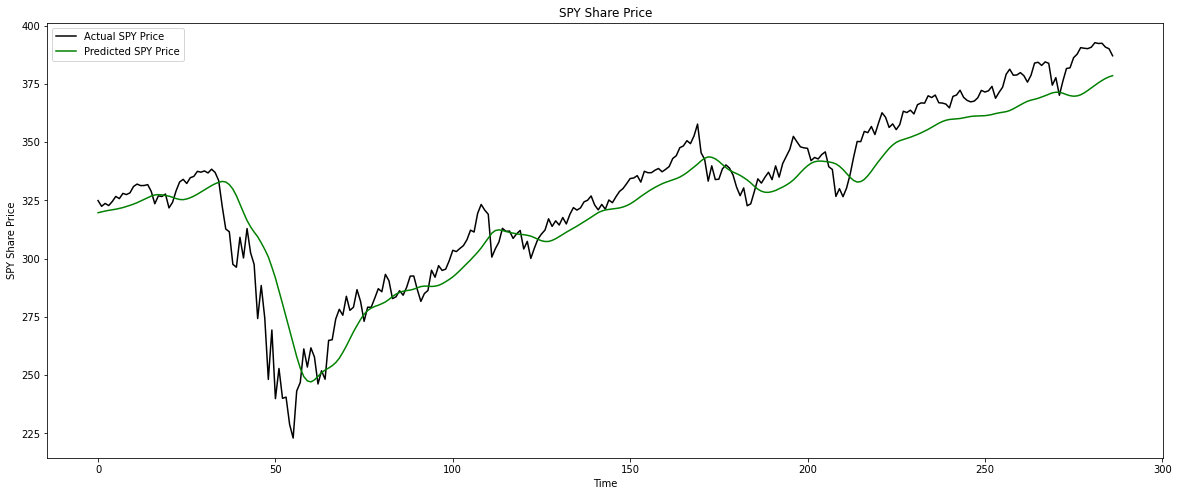

In [215]:
#Plot Test predictions

plt.figure(figsize=(20,8))
plt.plot(actual_prices, color='black', label=f'Actual {company} Price')
plt.plot(predicted_prices, color='green', label=f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [216]:
sub = np.array(predicted_prices).tolist()
sub2 = [item for sublist in sub for item in sublist]

In [217]:
df = pd.DataFrame(index = test_data.index)
df.insert(0,'Predicted', sub2)
df.insert(1,'Actual', np.array(actual_prices).tolist())

In [218]:
#Quitar las primeras 
df = df.iloc[20:]

In [219]:
df['Direc Predic'] = np.nan
df['Direc Real'] = np.nan
df['Resultado'] = np.nan

for i in range(1, len(df)):
  if df['Actual'][i] > df['Actual'][i-1]:
    df['Direc Real'][i] = 1
  else:
    df['Direc Real'][i] = 0
  
  if df['Predicted'][i] > df['Predicted'][i-1]:
    df['Direc Predic'][i] = 1
  else:
    df['Direc Predic'][i] = 0
  
  if df['Direc Predic'][i] == df['Direc Real'][i]:
    df['Resultado'][i] = 1
  else:
    df['Resultado'][i] = 0


In [220]:
df

,Predicted,Actual,Direc Predic,Direc Real,Resultado
Date,,,,,
2020-01-31,326.762299,321.730011,NaN,NaN,NaN
2020-02-03,326.290619,324.119995,0.0,1.0,0.0
2020-02-04,325.738098,329.059998,0.0,1.0,0.0
2020-02-05,325.335083,332.859985,0.0,1.0,0.0
2020-02-06,325.266907,333.980011,0.0,1.0,0.0
...,...,...,...,...,...
2021-02-16,375.414886,392.299988,1.0,0.0,0.0
2021-02-17,376.407532,392.390015,1.0,1.0,1.0
2021-02-18,377.287537,390.720001,1.0,0.0,0.0


In [221]:
porcentaje_aciertos = df["Resultado"].sum()/len(df)
print(f'{porcentaje_aciertos:.2%}')

52.06%


In [222]:
#Predict next day

real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

print(f'Prediction: {prediction}')

Prediction: [[378.69855]]
